# **Datos iniciales**

In [2]:
# En primer lugar importamos todas las librerias que vamos a utilizar en el notebook
import pynbody
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy import optimize
from astropy import units as unit
import sys
import pickle

In [3]:
# Generamos todas las rutas en donde tenemos la informacion requerida 
# Las rutas que no seran usadas a la hora de correr el notebook deben ser fijadas como COMENTARIOS

#datadir = '/media/juan/Pesquisa/Simulations_Chris_2021'
#datadir = '/home/danna01/Desktop/Auxiliatura/Galaxias'
#data_nuevo = '/media/danna01/Disk/SNAPSHOTS/Galaxias_Nuevas'
#data_viejo = '/media/danna01/Disk/SNAPSHOTS/Galaxias_Viejas'
data_nuevo = '/media/juan/Pesquisa/Simulations_Chris_2021'
data_viejo = '/media/juan/Pesquisa/Pesquisa/SNAPSHOTS'

In [4]:
#Estos son los diccionarios que definen los limites que seran utilizados para los plots de las galaxias para los
#calculos de densidad superficial radial para estrellas y para gases y para el calculo de la curva de rotacion
dicti = {}

galaxies = ['G0','G1', 'G2', 'G3']
#limites para graficar los plots
limites_densidad = {'G0':(0,20), 'G1':(0,25), 'G2':(0,20), 'G3':(0,55)}
#limites para calcular la h para el plot de estrellas y el de gas
limites_star = {'G0':(1.1,3.3),'G1':(1.5,4.5),'G2':(1.9,5.7),'G3':(2.8,8.4)}
limites_gas = {'G0':(3.3,9.9),'G1':(4.5,13.5),'G2':(5.7,17.1),'G3':(8.4,25.2)}
#limites en el eje y para los plots de gas, estrellas y para la curva de rotacion
limites_ejey_gas = {'G0':(-10, -2),'G1':(-6,-2),'G2':(-6,-2),'G3':(-6,-2)}
limites_ejey_star = {'G0':(-10, -2),'G1':(-10,0),'G2':(-6,0),'G3':(-10,0)}
limites_ejey_vel = {'G0':(-50, 120),'G1':(0,140),'G2':(0,180),'G3':(0,210)}

## FUNCIONES

### Perfiles de densidad superficial de gas y estrellas

In [5]:
# El scale-length del disco de gas
# El scale-length del disco estelar

In [6]:
# En esta celda, vamos a calcular los puntos intermedios de los radios de los anillos a partir de los cuales 
# vamos a hacer los calculos. En equivalencia con las barras de los histogramas, estariamos hallando el punto
# medio de cada una de estas barras.

# Radial surface density of the disk
# Hacer limites diferenciados (Para mas claridad refierase a la segunda linea del notebook)
def density(pos,mass,n,limits):
    r       = np.sqrt((pos[:,:2]**2).sum(axis=1)) # Azymutal radius 
    histo   = np.histogram(r,n,range=limits)
    #plt.hist(r,n,range=limits)
    bins     = (histo[1][:-1]+histo[1][1:])/2
    bn_mass = np.zeros(n)
    # Aca sacamos la sumatoria de la masa que esta concentrada en cada una de las barras del histograma.
    for i in range(n):
            bn_mass[i]      = mass[(r >= histo[1][i])*(histo[1][i+1] > r)].sum()
    dens    = bn_mass/(np.pi)/((histo[1][1:])**2-(histo[1][:-1])**2)
    return histo,bins,dens

In [7]:
# esta celda es necesaria para calcular el error cuadrado mínimo para hallar la linea recta que se ajuste
# mejor a los datos obtenidos para la densidad superficial

def fit_exponential(x,y,limits):
    # Con la siguiente linea nos aseguramos de que los datos que tomemos para X esten en el intervalo que
    # definimos anteriormente, la multiplicacion es porque se considera que si ambos son verdaderos dara 1 y
    # seran considerados y si da cero, seran omitidos (en caso de que no cumpla con ambas condiciones)
    mask = (x >= limits[0])*(x <= limits[1])
    x = x[mask]
    y = y[mask]
    y = np.log10(y)
    # initial guess (punto inicial aproximado necesario para que la funcion de minimo cuadrado pueda funcionar)
    m_0 = (y[-1] - y[0])/(x[-1] - x[0])
    b_0 = y[0] - m_0*x[0]
    # Aca definimos la funcion de error y aplicamos el minimo cuadrado para hallar la funcion que mejor se acomode
    errfun  = lambda p: np.ravel(p[0]*x[:]+p[1]-y[:])
    fitparam = optimize.leastsq(errfun,[m_0,b_0],full_output=1)[0]
    m = fitparam[0]
    b = fitparam[1]
    return m,b

In [8]:
# esta celda simplemente funciona para definir todos los parametros de las graficas que son generadas para cada 
# snapshot y pues para cada tipo de dato (estrella, gas, etc.)
# Note que las funciones son de caracter exponencial y logaritmico.
def plot_exponential(bins,dens,m,b,filename):
    R = (-1./m)*np.log10(np.e)
    fig = plt.figure(figsize=(10, 7))
# importante: el calculo del valor de 'h'
# Para calcular el valor de h se consideran limites diferenciamos que permitan un calculo en regiones de la grafica
# mas lineales, para un mejor arreglo
    plt.plot(bins, np.log10(dens), 'r.', label = 'h = {a:3.2f}'.format(a = R))
    plt.plot(bins,m*bins+b,'-k')
    plt.legend(fontsize = 20, loc=0)
    plt.title('Perfil de densidad superficial', fontsize = 18)
    plt.xlabel('Radio [Kpc]', fontsize = 20)
    plt.ylabel(r'$\rho$ [$1x10^{10}$ Msol/$kpc^{2}$]', fontsize = 20)
    plt.grid()
    plt.savefig(filename)
    plt.clf()
    plt.close()

### Curva de rotacion

In [9]:
# Radio azimutal 
# para ello, utilizamos los datos de la posicion tanto en x como en y
def RGas(data):
    Rg = np.sqrt(data.gas['pos'][:,0]**2 + data.gas['pos'][:,1]**2)
    return Rg

In [10]:
# Velocidad tangencial
def Vcartesian2polar(pos,vel):
    Vtan    = np.zeros(pos.shape[0])
    Vrad    = np.zeros(pos.shape[0])
    norm    = np.sqrt(pos[:,0]**2+pos[:,1]**2)
    Vtan    = (vel[:,1]*pos[:,0]-vel[:,0]*pos[:,1])/norm
    Vrad    = (vel[:,0]*pos[:,0]+vel[:,1]*pos[:,1])/norm
    return Vtan,Vrad

In [11]:
# Dada una secuencia de puntos, que serán los extremos
# de las casillas de los bins de un histograma, saca los puntos medios
# de cada casilla como referencia
def radios(points):
    radii     = (points[:-1]+points[1:])/2
    return radii 

In [12]:
# Función que retorna la curva de rotación para las partículas
# de gas en una galaxia tipo disco en rotación. 
# Lo hace con bins circulares, tomando en cada bin la media de
# las velocidades tangenciales, pero ponderada por la masa de cada partícula
# Es decir, en cada bin define:
# <V_cir> = Sum(V_tan * mass) / Sum(mass)
# Bajo condiciones normales, cada particula valdria lo mismo, pero en este caso, el valor de cada
# particula dependera de su masa.

def RotCurvGas(data,points):
    a = np.histogram(RGas(data), bins=points,  weights= Vcartesian2polar(data.gas["pos"],data.gas["vel"])[0]*data.gas['mass'])
    b = np.histogram(RGas(data), bins=points,  weights= data.gas['mass'])
    Vel = (a[0]/b[0])
    return a[1][0:len(points)-1],Vel

In [13]:
# Calcula la curva de rotacion, la grafica y almacena la figura
# Returna el valor máximo de la curva de rotación
def plot_rot_curve(gal,data,filename):
    r_bins = np.arange(limites_densidad['G0'][0],limites_densidad['G0'][1],0.5)
    Vel = RotCurvGas(data,r_bins)[1]
    r = radios(r_bins)
    plt.plot(r,Vel)
    
    fig = plt.figure(figsize=(10, 7))
    plt.plot(r,Vel)
    plt.title('Curva de rotación del gas', fontsize = 18)
    plt.xlabel('Radio [Kpc]', fontsize = 20)
    plt.ylabel(r'V_{circular}$ [km / s]', fontsize = 20)
    plt.grid()
    plt.savefig(filename)
    plt.clf()
    plt.close()
    
    return np.nanmax(Vel)

## Compilacion de los diccionarios

In [14]:
# En esta celda, estamos defiendo la funcion con la cual vamos a compilar los datos de las galaxias
# de cada una de las simulaciones, para esto, requeriremos la ruta para llegar a los datos, los limites
# para las galaxias, y los valores maximos y minimos de los snaps que tomaremos en cuenta. 

def compile_data(origin,gal,minsnap,maxsnap,stepsnap):
    dicti = {}
    #A continuacion definiremos la ruta de la cual se tomaran cada uno de los snaps
    for snap in np.arange(minsnap,maxsnap,stepsnap): 
        
        # Esto va a imprimir en pantalla un letrero a cada 10 snapshots iterados
        # Para ayudarnos a saber por dónde va
        if not snap % 10:
            print("working in snapshots number ",snap)
        
        snap = str(snap).zfill(3)        
        data = pynbody.load(origin+'/'+gal+'/snapshot_'+snap+'.hdf5')
        dicti[snap] = {}
            
            
            # y en las siguientes lineas daremos las especificaciones de las graficas que queremos que se
            # generen a partir de los plots, junto con la ruta donde seran guardadas, ademas de que las 
            # almacenaremos en el diccionario que estamos generando, este proceso se repite para cada uno de los
            # datos: Velocidad maxima de rotacion, numero de estrellas, h del gas y de las estrellas.
           
        V_max = plot_rot_curve(gal,data,filename='plots_nuevos/'+gal+'/'+gal+'_rotcurve_'+snap+'.jpg')
        dicti[snap]['Vmax'] = V_max
            
        N_star = data.star['mass'].size
        dicti[snap]['Nstar'] = N_star

        histo,bins,dens = density(data.gas['pos'],data.gas['mass'],n=20,limits=limites_densidad[gal])
        m,b = fit_exponential(bins,dens,limits=limites_gas[gal])
        plot_exponential(bins,dens,m,b,filename='plots_nuevos/'+gal+'/'+gal+'_gas_'+snap+'.jpg')
        dicti[snap]['h_gas'] = -1/m*np.log10(np.e)
        
        histo,bins,dens = density(data.star['pos'],data.star['mass'],n=20,limits=limites_densidad[gal])
        m,b = fit_exponential(bins,dens,limits=limites_star[gal])
        plot_exponential(bins,dens,m,b,filename='plots_nuevos/'+gal+'/'+gal+'_star_'+snap+'.jpg')
        dicti[snap]['h_star'] = -1/m*np.log10(np.e)

    return dicti

In [15]:
# Finalizada la compilación de datos en un diccionario
# Aqui se extraen los valores de cada cantidad secuencialmente
def extract_qtt(dictionary,quantity):
    if quantity == 'snapshots':
        lista = [np.float(key) for key in dictionary.keys()]
    else:
        # list comprehension
        lista = [dictionary[snap][quantity] for snap in dictionary.keys()]
    return lista

In [34]:
# Aca vamos a definir las funciones que vamos a graficar con los datos que se extraen del diccionario
# Para esto, primero definiremos las variables a graficas en este caso para los datos nuevos:
def show_results(dicti, dicti_old, gal):
    snapshots_new = extract_qtt(dicti,'snapshots')
    h0_gas_new = extract_qtt(dicti,'h_gas')
    h0_star_new = extract_qtt(dicti,'h_star')
    N_star_new = extract_qtt(dicti,'Nstar')
    Vmax_new = extract_qtt(dicti,'Vmax')
    
    # Aca hacemos lo mismo para los datos viejos:
    snapshots_old = extract_qtt(dicti_old,'snapshots')
    h0_gas_old = extract_qtt(dicti_old,'h_gas')
    h0_star_old = extract_qtt(dicti_old,'h_star')
    N_star_old = extract_qtt(dicti_old,'Nstar')
    Vmax_old = extract_qtt(dicti_old,'Vmax')
    
    # Definimos el tamaño del plot
    plt.figure(figsize=(12,4))
    
    # Definimos cada una de las posiciones de los plots, los histogramas y las posiciones que les vamos a dar,
    # asi como sus especificaciones para cada una de las variables.
    # Para los valores de Y en el plot hemos asignado valores arbitrarios, con el unico fin de poder visualizar 
    # la informacion.
    
    # Para el histograma del gas
    plt.subplot(131)
    plt.hist(h0_gas_new,bins=5,color='green')
    plt.title(gal + '  h0 GAS')
    #Como solo existen datos viejos para las galaxias G0 y G1 debemos especificar que los plots son solo
    #para esos datos con las siguientes lineas
    if gal in ['G0','G1']:
        x = h0_gas_old
        y = np.array([50,50,50])
        plt.plot(x,y, "ok")
    
    # Para el histograma de las estrellas
    plt.subplot(132)
    #Como solo existen datos viejos para las galaxias G0 y G1 debemos especificar que los plots son solo
    #para esos datos con las siguientes lineas
    if gal in ['G0','G1','G3']:
        plt.hist(h0_star_new,bins=5,color='orange')
        plt.title(gal + '  h0 STARS')
    if gal == 'G2':
        h0_gas_new = extract_qtt(super_dict['G2'],'h_star')
        plt.hist(h0_star_new,bins=20,color='green',range=(1,5))
        plt.title(gal + '  h0 GAS')
    if gal in ['G0','G1']:
        x = h0_star_old
        y = np.array([50,50,50])
        plt.plot(x,y,"ok")
    
    #Para la velocidad maxima
    plt.subplot(133)
    plt.hist(Vmax_new,bins=5,color='red')
    plt.title(gal + '  Max Velocity')
    #Como solo existen datos viejos para las galaxias G0 y G1 debemos especificar que los plots son solo
    #para esos datos con las siguientes lineas
    if gal in ['G0','G1']:
        x = Vmax_old
        y = np.array([50,50,50])
        plt.plot(x,y,"ok")

## Generacion de los diccionarios

In [ ]:
# Con estas lineas, vamos a compilar el diccionario, para esto, utilizaremos la funcion de compile data
# y debemos aclarar los minimos, maximos y el espaciado entre los snaps considerados
# Tambien se debe hacer claridad en los valores de galaxias considerados.
# ESTA CELDA SOLO SE DEBE CORRER UNA VEZ (NO CORRERLA NUEVAMENTE)

#super_dict = {}
#for gal in galaxies:
    #super_dict[gal] = compile_data(data_nuevo,gal,minsnap=0,maxsnap=601,stepsnap=1)

# Con estas líneas vamos a salvar el diccionario directamente en un formato de python
# para que las próximas veces podamos simplemente leerlo, sin tener que volver a
# hacer toda la compilación leyendo directo de los snapshots
# Va a quedar guardado con el numbre de archivo: 'compilation_new'

#file = open('diccionarios_nuevos/compilation_new', 'wb')
#pickle.dump(super_dict, file)
#file.close() 

working in snapshots number  100


/home/juan/anaconda3/lib/python3.8/site-packages/pynbody/snapshot/gadgethdf.py:508: RuntimeWarning: No unit information found!
  warnings.warn("No unit information found!", RuntimeWarning)
/home/juan/anaconda3/lib/python3.8/site-packages/pynbody/snapshot/gadgethdf.py:572: RuntimeWarning: No unit information found: using gadget-units.
  warnings.warn(
<ipython-input-19-0c67cf86e750>:10: RuntimeWarning: divide by zero encountered in log10
  plt.plot(bins, np.log10(dens), 'r.', label = 'h = {a:3.2f}'.format(a = R))
/home/juan/anaconda3/lib/python3.8/site-packages/pynbody/snapshot/gadgethdf.py:508: RuntimeWarning: No unit information found!
  warnings.warn("No unit information found!", RuntimeWarning)
/home/juan/anaconda3/lib/python3.8/site-packages/pynbody/snapshot/gadgethdf.py:572: RuntimeWarning: No unit information found: using gadget-units.
  warnings.warn(


working in snapshots number  300


<ipython-input-19-0c67cf86e750>:10: RuntimeWarning: divide by zero encountered in log10
  plt.plot(bins, np.log10(dens), 'r.', label = 'h = {a:3.2f}'.format(a = R))
/home/juan/anaconda3/lib/python3.8/site-packages/pynbody/snapshot/gadgethdf.py:508: RuntimeWarning: No unit information found!
  warnings.warn("No unit information found!", RuntimeWarning)
/home/juan/anaconda3/lib/python3.8/site-packages/pynbody/snapshot/gadgethdf.py:572: RuntimeWarning: No unit information found: using gadget-units.
  warnings.warn(


working in snapshots number  500


<ipython-input-19-0c67cf86e750>:10: RuntimeWarning: divide by zero encountered in log10
  plt.plot(bins, np.log10(dens), 'r.', label = 'h = {a:3.2f}'.format(a = R))
/home/juan/anaconda3/lib/python3.8/site-packages/pynbody/snapshot/gadgethdf.py:508: RuntimeWarning: No unit information found!
  warnings.warn("No unit information found!", RuntimeWarning)
/home/juan/anaconda3/lib/python3.8/site-packages/pynbody/snapshot/gadgethdf.py:572: RuntimeWarning: No unit information found: using gadget-units.
  warnings.warn(


working in snapshots number  100


<ipython-input-19-0c67cf86e750>:10: RuntimeWarning: divide by zero encountered in log10
  plt.plot(bins, np.log10(dens), 'r.', label = 'h = {a:3.2f}'.format(a = R))
/home/juan/anaconda3/lib/python3.8/site-packages/pynbody/snapshot/gadgethdf.py:508: RuntimeWarning: No unit information found!
  warnings.warn("No unit information found!", RuntimeWarning)
/home/juan/anaconda3/lib/python3.8/site-packages/pynbody/snapshot/gadgethdf.py:572: RuntimeWarning: No unit information found: using gadget-units.
  warnings.warn(


working in snapshots number  300


<ipython-input-19-0c67cf86e750>:10: RuntimeWarning: divide by zero encountered in log10
  plt.plot(bins, np.log10(dens), 'r.', label = 'h = {a:3.2f}'.format(a = R))
/home/juan/anaconda3/lib/python3.8/site-packages/pynbody/snapshot/gadgethdf.py:508: RuntimeWarning: No unit information found!
  warnings.warn("No unit information found!", RuntimeWarning)
/home/juan/anaconda3/lib/python3.8/site-packages/pynbody/snapshot/gadgethdf.py:572: RuntimeWarning: No unit information found: using gadget-units.
  warnings.warn(


working in snapshots number  500


<ipython-input-19-0c67cf86e750>:10: RuntimeWarning: divide by zero encountered in log10
  plt.plot(bins, np.log10(dens), 'r.', label = 'h = {a:3.2f}'.format(a = R))


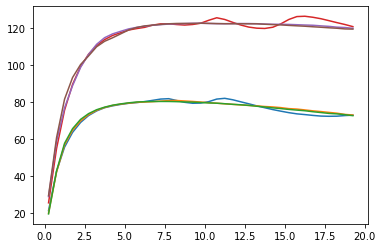

In [34]:
# SOLO SE DEBE CORRER UNA VEZ (EVITE CORRERLO NUEVAMENTE)
# Aca se repite exactamente el mismo proceso para compilar los datos para el otro diccionario para las 
# simulaciones de galaxias antiguas, el proceso es exactamente el mismo, solo se deben cambiar los valores de los
# snaps de acuerdo a la informacion que se tenga.

#super_dict_old = {}
#for gal in ['G0','G1']:
    #super_dict_old[gal] = compile_data(data_viejo,gal,minsnap=100,maxsnap=600,stepsnap=200)

# Se repite el proceso para el otro conjunto de datos, con las lineas siguientes se va a salvar el diccionario
# de los datos antiguos, con el nombre que se desee, en este caso quedo como 'compilation_old'

#file = open('diccionarios_nuevos/compilation_old', 'wb')
#pickle.dump(super_dict_old, file)
#file.close()

**Referencia**
*Con el objetivo de comparar la informacion obtenida se anexa a continuacion una tabla donde se resume la informacion del documento que se tomo como referencia para estos datos, para mas informacion puede consultar el siguiente [enlace](https://ui.adsabs.harvard.edu/abs/2010MNRAS.403...17J/abstract)*
 

Modelo | Masa Total [$M_\odot$] | Masa barionica [$M_\odot$] | Scale-length estrellas [kpc] | Scale-length gas [kpc] | Masa Gas [$M_\odot$] | Vmax [km s$^{-1}$]
:-------: | :----------: | :-------: | :-------: | :-------: | :-------: | :-------:
G0 | 5.1 $\cdot 10^{10}$ | $1.6 \cdot 10^{9}$ | 1.1 | 3.3 | 6.08 $\cdot 10^{8}$ | 67 
G1 | $2 \cdot 10^{11}$    | $7 \cdot 10^{9}$ | 1.5 | 4.5 |  2.03 $\cdot 10^{9}$| 103
G2 | 5.1 $\cdot 10^{11}$  | $1.98 \cdot 10^{10}$ | 1.9 | 5.7 | 4.55 $\cdot 10^{9}$ | 139
G3 | 1.16 $\cdot 10^{12}$ | $6.22 \cdot 10^{10}$ | 2.8 | 8.4 | 1.24 $\cdot 10^{10}$ | 192

## Visualizacion de la informacion y generacion de los histogramas

In [17]:
# Así lo leemos después de haberlo almacenado
# Va a quedar importado en la variable 'super_dict'

file = open('diccionarios_nuevos/compilation_new', 'rb')
super_dict = pickle.load(file)
file.close()

In [18]:
# Así lo leemos después de haberlo almacenado
# Va a quedar importado en la variable 'super_dict_old'

file = open('diccionarios_nuevos/compilation_old', 'rb')
super_dict_old = pickle.load(file)
file.close()
#Estas lineas que se agregan son necesarias porque el diccionario no tiene la informacion requerida para las 
#galaxias G2 y G3, por ende, se agregan como diccionarios vacios para no generar un error a la hora de aplicar
#la funcion de graficas.
super_dict_old['G2']={} 
super_dict_old['G3']={} 

<ipython-input-15-e1f46a1ee7e0>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lista = [np.float(key) for key in dictionary.keys()]
<ipython-input-15-e1f46a1ee7e0>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lista = [np.float(key) for key in dictionary.keys()]
<ipython-input-15-e1f46a1ee7e0>:5: DeprecationWarning: `np.float` is a d

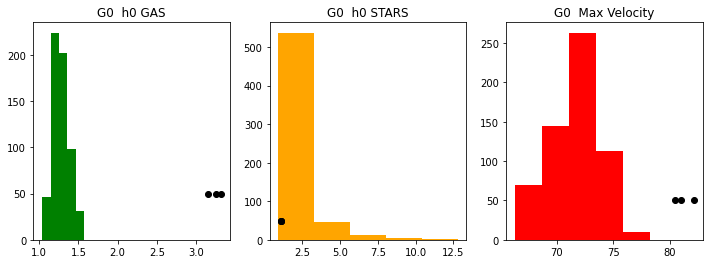

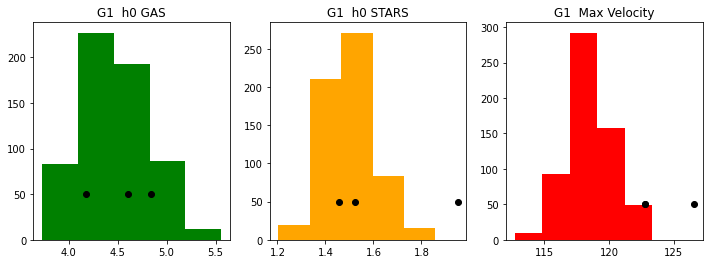

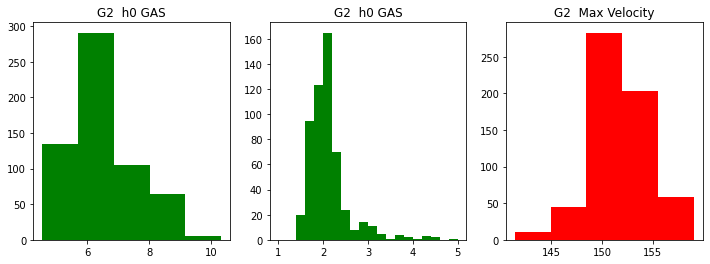

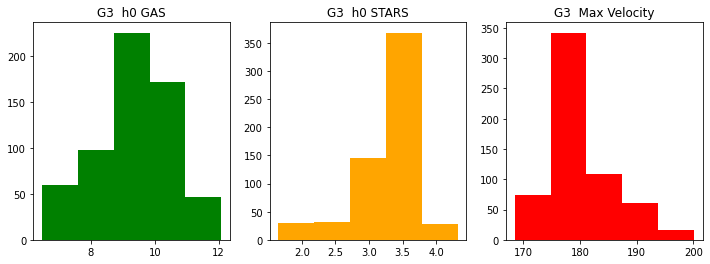

In [35]:
# Con esta linea vamos a comparar los datos obtenidos para las galaxias de ambas bases de datos en una misma 
#grafica para esto nuevamente usaremos la funcion de show results y con esta, utilizaremos los dos
# diccionarios en donde esta almacenada la informacion, con sus respectivos limites.
for gal in galaxies:
    show_results(super_dict[gal],super_dict_old[gal],gal)

### Herramientas Adicionales

In [38]:
#SI NO REQUIERE DE LAS VERIFICACIONES, SIMPLEMENTE FIJELAS COMO COMENTARIOS

# Si se tiene duda de que el diccionario este efectivamente almacenado recurra a estas lineas, de lo contrario
# dejelas como COMENTARIOS, la linea a utilizar dependera de la duda que se presente (ubique el diccionario
# que le genera duda y corra esa linea)

#print(super_dict)
#print(super_dict_old)

# Con esta linea puede ver el tamaño de los archivos almacenados en la carpeta en la que trabaje, identifique
# que los tamaños de los diccionarios sea un valor logico
# de lo contrario, fijelo como COMENTARIO

#ls -lh

#COn esta linea puede verificar las galaxias contenidas en el diccionario
#print(super_dict.keys())

#COn esta linea puede observar la informacion contenida en el diccionario para la galaxia que especifique
#print(super_dict['G3'])